import everything

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from skimage import measure
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.util import img_as_float
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_score
from skimage.measure import label, regionprops
from openniftiimages import load_and_display_nifti
from scipy.spatial.distance import directed_hausdorff
from skimage.segmentation import find_boundaries, mark_boundaries

read the file to get patient ID and the slices used

In [2]:
patient_info_file = r'G:\Annekoos Schaap - code\Data\All_imaging_features_NKI.xlsx'
base_nifti_path = r'G:\NKI dataset\Data_nifti'

# Read the patient info
patient_info_df = pd.read_excel(patient_info_file)

read the mask area coordinates

In [3]:
# read Excel
filename = 'coordinates.xlsx'
df = pd.read_excel(filename, sheet_name='Sheet1', header=None)
filename_1 = 'coordinates_1.xlsx'
df_1 = pd.read_excel(filename_1, sheet_name='Sheet1', header=None)
print(df)

print(len(df))
print(len(patient_info_df))

      0    1    2    3
0   193  199  370  298
1   137  139  342  276
2   177  197  352  292
3   153  245  352  360
4   175  195  340  316
5   173  205  332  308
6   183  171  324  270
7   161  187  346  318
8   183  201  348  306
9   175  205  348  312
10  177  199  346  334
11  141  209  360  340
12  177  225  366  338
13  143  159  362  330
14  169  189  338  302
15  193  231  346  336
16  159  203  338  310
17  157  215  350  318
18  189  231  336  312
19  175  267  342  384
20  195  233  346  352
21  187  227  342  306
22  183  221  344  320
23  161  171  384  304
24  183  245  346  326
25  173  221  352  342
26   81   92  164  146
27  188   89  387  263
28  203  183  373  331
29  303  295  410  371
30  298  276  415  355
31  284  312  415  412
32  268  262  415  382
33  309  342  401  415
34  303  295  385  371
35
35


In [4]:
segment = []
mask_corruption = []
mask_prediction = []

from the table given, go through the columns of patient name and slice.
combine the path of T2.nii for each patient --> 'nifti_path'
load the .nii file and reach for the data
make the slice rotated to the right angel and rescale the image --> 'rescaled_image'
corrupt the image based on the coordinates --> 'region'
apply SLIC within the corrupted image: 'segments' are the labels of all superpixels from 1; 'boundaries_1' is a boolen matrix marking boundaries and other areas; 'image_with_boundaries_1' is a RGB image overlapping the image and the boundaries
read the prostate mask from the path --> 'mat_file_path'
keep the mask as boolen and corrupt the mask according to the coordinates
find the boundaries of the prostate mask --> 'prostate_boundaries'


In [5]:
# Define the threshold
threshold = 0.6

In [69]:
# def extract_boundary_points(mask):
#     # 提取边界点
#     contours = measure.find_contours(mask, level=0.5)
#     points = []
#     for contour in contours:
#         for point in contour:
#             points.append(point)
    
#     return np.array(points)

In [6]:
def extract_boundary_points(mask):
    if mask.ndim != 2 or mask.size == 0:
        print("掩模形状无效:", mask.shape)
        return np.array([])  # 如果掩模不是二维或为空，则返回一个空数组

    contours = measure.find_contours(mask, level=0.5)
    points = []
    for contour in contours:
        for point in contour:
            points.append(point)
    return np.array(points)

In [7]:
def calculate_metrics(predicted_mask, prostate_mask, threshold):
    # # Initialize an empty image for the predicted mask
    # predicted_mask = np.zeros_like(prostate_mask, dtype=int)

    # # For each superpixel, calculate its overlap with the prostate mask
    # for region in regionprops(label(segments)):
    #     # Extract the superpixel region
    #     superpixel = (segments == region.label)
        
    #     # Calculate overlap with the prostate mask
    #     overlap = np.sum(superpixel & prostate_mask) / np.sum(superpixel)
        
    #     # If overlap exceeds the threshold, consider it as part of the prostate
    #     if overlap > threshold:
    #         predicted_mask[superpixel] = 1

    
    # Dice score 
    dice_score = 2 * np.sum(predicted_mask & prostate_mask) / (np.sum(predicted_mask) + np.sum(prostate_mask))

    # Jaccard index Dice score: 2 * Jaccard index / (1 + Jaccard index)
    jaccard_index = jaccard_score(prostate_mask.flatten(), predicted_mask.flatten())
    dice_score_from_jaccard = 2 * jaccard_index / (1 + jaccard_index)

    # Hausdorff distance
    u = np.transpose(np.nonzero(prostate_mask))
    v = np.transpose(np.nonzero(predicted_mask))
    hausdorff_dist = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

    print(prostate_mask.shape)
    print(predicted_mask.shape)



    # # 提取两个掩模的边界点
    # points1 = extract_boundary_points(prostate_mask)
    # points2 = extract_boundary_points(predicted_mask)

    # print(points1.shape)
    # print(points2.shape)
    
    # # 计算点集之间的距离
    # distances_1_to_2 = cdist(points1, points2, metric='euclidean')
    # distances_2_to_1 = cdist(points2, points1, metric='euclidean')
    
    # # 找到最短距离并计算平均值
    # min_distances_1_to_2 = np.min(distances_1_to_2, axis=1)
    # min_distances_2_to_1 = np.min(distances_2_to_1, axis=1)
    
    # # 计算两个方向的平均表面距离
    # asd_1_to_2 = np.mean(min_distances_1_to_2)
    # asd_2_to_1 = np.mean(min_distances_2_to_1)
    
    # # 返回双向平均表面距离
    # asd = (asd_1_to_2 + asd_2_to_1) / 2

    return dice_score, dice_score_from_jaccard, hausdorff_dist

添加！！！！！！！！！！！！！！！！

In [71]:
# listPats = ['MRI002', 'MRI045', 'MRI056']
# sliceloc = [10, 20, 10]

# import nibabel as nib

# def load_mri_data(patient_id):
#     file_path = f'Z:/GENIM/NKI dataset/Data_nifti/{patient_id}/NIFTIs/T2.nii'
#     mri_data = nib.load(file_path)
#     return mri_data.get_fdata()

# from scipy.io import loadmat

# def load_mask(patient_id, slice_number):
#     mask_path = f'Z:/GENIM/NKI dataset/Data_nifti/logic_adjusted_masks/adjusted_patient_{patient_id}/adjusted_prostate_slice_{patient_id}/adjusted_prostate_slice_{slice_number}.mat'
#     mask_data = loadmat(mask_path)
#     return mask_data['logic_image']

# from skimage.transform import resize
# import matplotlib.pyplot as plt
# import numpy as np

# def overlay_mask(mri_data, mask, slice_number, patient_id):
#     slice_data = mri_data[:, :, slice_number]
#     if mask.shape != slice_data.shape:
#         mask = resize(mask, slice_data.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)
    
#     plt.figure()
#     plt.imshow(slice_data.T, cmap='gray')  # Transpose to match MATLAB's imagesc
#     plt.contour(mask.T, colors='w')  # Transpose mask for correct overlay
#     plt.title(f'Prostate contour overlaid on T2w - {patient_id}')
#     plt.axis('off')
#     plt.show()

# for patient_id, slice_number in zip(listPats, sliceloc):
#     mri_data = load_mri_data(patient_id)
#     mask = load_mask(patient_id, slice_number)
#     overlay_mask(mri_data, mask, slice_number, patient_id)


(704, 704)
(704, 704)
(111, 122)
(90, 99)


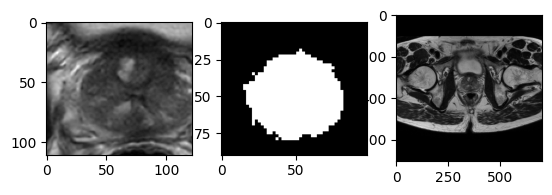

In [8]:
path = r'G:\NKI dataset\Data_nifti\MRI056\NIFTIs\T2.nii'
nifti_image = nib.load(path)
data_nifti = nifti_image.get_fdata()

mat_file_path_1 = r'G:\NKI dataset\Data_nifti\logic_adjusted_masks\adjusted_patient_MRI056\adjusted_prostate_slice_MRI056\adjusted_prostate_slice_12.mat'
mat_1 = scipy.io.loadmat(mat_file_path_1)
prostate_mask_1 = mat_1['logic_image']

# image_slice_1 = data_nifti[:, :, 12]

# if data_nifti.shape[0] == prostate_mask_1.shape[0] and data_nifti.shape[1] == prostate_mask_1.shape[1]:
#         prostate_mask_1 = mat_1['logic_image']
# else:
#         prostate_mask_1 = scipy.misc.imresize(prostate_mask_1, size=data_nifti[:, :, 12], interp='cubic')
#         # prostate_mask_1 = resize(prostate_mask_1, data_nifti[:, :, 12].shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)

# print(data_nifti.shape)
# print(prostate_mask_1.shape)

image_slice_1 = data_nifti[:, :, 12]
image_nifti_1 = np.rot90(image_slice_1, 3)
minni_1 = np.min(image_nifti_1)
maxni_1 = np.max(image_nifti_1)
rescaled_image_1 = ((image_nifti_1 - minni_1) / (maxni_1 - minni_1)) * 255
rescaled_image_1 = rescaled_image_1.astype(np.uint8)
area_1 = rescaled_image_1[270:381, 283:405]
print(image_nifti_1.shape)
print(rescaled_image_1.shape)
print(area_1.shape)
# area_1 = rescaled_image_1[283:405, 270:381]

# image_slice_2 = data_nifti[:, :, 12]
# image_nifti_2 = np.rot90(image_slice_2, 3)
# minni_2 = np.min(image_nifti_2)
# maxni_2 = np.max(image_nifti_2)
# rescaled_image_2 = ((image_nifti_2 - minni_2) / (maxni_2 - minni_2)) * 255
# rescaled_image_2 = rescaled_image_2.astype(np.uint8)
# area_2 = rescaled_image_2[190:280, 201:300]



# mat_file_path_2 = r'G:\NKI dataset\Data_nifti\logic_adjusted_masks\adjusted_patient_MRI056\adjusted_prostate_slice_MRI056\adjusted_prostate_slice_10.mat'


# mat_2 = scipy.io.loadmat(mat_file_path_2)


# if prostate_mask_1.shape != rescaled_image_1.shape:
#             prostate_mask_1 = resize(prostate_mask_1, rescaled_image_1.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)
prostate_mask_1 = prostate_mask_1.astype(bool)
prostate_mask_1 = prostate_mask_1[190:280, 201:300]
# prostate_mask_1 = prostate_mask_1[270:381, 283:405]
print(prostate_mask_1.shape)


# prostate_mask_2 = mat_2['logic_image']
# prostate_mask_2 = prostate_mask_2.astype(bool)
# prostate_mask_2 = prostate_mask_2[190:280, 201:300]



# plt.figure(figsize=(10, 10))
# plt.subplot(3,2,1)
# plt.imshow(area_1,cmap='gray')
# plt.subplot(3,2,2)
# plt.imshow(area_2,cmap='gray')
# plt.subplot(3,2,3)
# plt.imshow(prostate_mask_1,cmap='gray')
# plt.subplot(3,2,4)
# plt.imshow(prostate_mask_2,cmap='gray')
# plt.subplot(3,2,5)
# plt.imshow(rescaled_image_1,cmap='gray')
# plt.subplot(3,2,6)
# plt.imshow(rescaled_image_2,cmap='gray')
# plt.figure(figsize=(10, 10))
plt.figure()
plt.subplot(1,3,1)
plt.imshow(area_1,cmap='gray')

plt.subplot(1,3,2)
plt.imshow(prostate_mask_1,cmap='gray')

plt.subplot(1,3,3)
plt.imshow(rescaled_image_1,cmap='gray')


In [73]:
for index, row in patient_info_df.iterrows():
    patient_name = row['Patient name ']
    slice_no = int(np.floor(row['Slice no. ']))  # Assuming 'Slice no.' column contains integers
    print(f"Processing {patient_name}, Slice {slice_no}...")
    # Construct the path to the NIfTI file
    nifti_path = os.path.join(base_nifti_path, patient_name, 'NIFTIs', 'T2.nii')
    
    # Load the NIfTI image
    nifti_image = nib.load(nifti_path)
    data_nifti = nifti_image.get_fdata()
    
    # Check if the number of dimensions is correct
    if data_nifti.ndim == 3:
        # Get the specific slice
        image_slice = data_nifti[:, :, slice_no]
        
        # Process the image slice
        image_nifti = np.rot90(image_slice, 3)
        minni = np.min(image_nifti)
        maxni = np.max(image_nifti)
        rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
        rescaled_image = rescaled_image.astype(np.uint8)

        # Get coordinates for the current patient
        # Assuming each patient has a corresponding row in the coordinates Excel file
        
        minX, minY, maxX, maxY = df.iloc[index, :4]
        minX_1, minY_1, maxX_1, maxY_1 = df_1.iloc[index, :4]
        
        # Crop the region from the rescaled image
        # Ensure that the indices do not go out of bounds
        y_min = max(minY - 25, 0)
        y_max = min(maxY + 10, rescaled_image.shape[0])
        x_min = max(minX - 20, 0)
        x_max = min(maxX + 20, rescaled_image.shape[1])
        area = rescaled_image[y_min:y_max, x_min:x_max]
        print(area.shape)

        # print(region.shape)
        # print(f"minX: {minX}, minY: {minY}, maxX: {maxX}, maxY: {maxY}")

        # segments = slic(region, n_segments=round(region.shape[0]*region.shape[1]/1000), compactness=0.1, sigma=1, start_label=1, channel_axis=None)
        segments = slic(area, n_segments=30, compactness=0.05, sigma=1, start_label=1, channel_axis=None)
        boundaries_1 = find_boundaries(segments, mode='inner')
        image_with_boundaries_1 = mark_boundaries(area, boundaries_1, color=(1, 0, 0))

        mat_file_path = os.path.join(base_nifti_path, 'logic_adjusted_masks', f'adjusted_patient_{patient_name}', f'adjusted_prostate_slice_{patient_name}', f'adjusted_prostate_slice_{slice_no}.mat')
        mat = scipy.io.loadmat(mat_file_path)
        prostate_mask = mat['logic_image']
        # prostate_mask = prostate_mask.astype(bool)
        # prostate_mask = prostate_mask[y_min:y_max, x_min:x_max]
        # print(prostate_mask.shape)

        

        y_min_1 = max(minY_1 - 25, 0)
        y_max_1 = min(maxY_1 + 10, prostate_mask.shape[0])
        x_min_1 = max(minX_1 - 20, 0)
        x_max_1 = min(maxX_1 + 20, prostate_mask.shape[1])
        
        prostate_mask = prostate_mask[y_min_1:y_max_1, x_min_1:x_max_1]

        if prostate_mask.shape != area.shape:
            prostate_mask = resize(prostate_mask, area.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)

        print(prostate_mask.shape)

        predicted_mask = np.zeros_like(prostate_mask)
        print(area.dtype, area.shape)
        
        for region in regionprops(label(segments)):
            # Extract the superpixel region
            superpixel = (segments == region.label)
            
            # Calculate overlap with the prostate mask
            overlap = np.sum(superpixel & prostate_mask) / np.sum(superpixel)
            
            # If overlap exceeds the threshold, consider it as part of the prostate
            if overlap > threshold:
                predicted_mask[superpixel] = 1

        prostate_boundaries = find_boundaries(prostate_mask, mode='inner')
        prediction_boundaries = find_boundaries(predicted_mask, mode='inner')
        print(area.dtype, area.shape)

        image_with_boundaries_2 = mark_boundaries(image_with_boundaries_1, prostate_boundaries, color=(0, 0, 1))
        image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))

        plt.figure(figsize=(10, 10))
        # plt.imshow(area, cmap='gray')
        # plt.imshow(label2rgb(prediction_boundaries, bg_label=0, colors=['red'], bg_color=None, alpha=0.1))
        # plt.imshow(label2rgb(prostate_boundaries, bg_label=0, colors=['blue'], bg_color=None, alpha=0.1))
        plt.imshow(image_with_boundaries_3, cmap='gray')
        plt.axis('off')

        save_folder = r'C:\Users\alexg\Desktop\study\graduation project\code\mask_comparison'
        os.makedirs(save_folder, exist_ok=True)
        save_path = os.path.join(save_folder, f'patient_{patient_name}_comparison.png')

        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        save_path

        segment.append(segments)

        mask_corruption.append(prostate_mask)
        mask_prediction.append(predicted_mask)

    print(f"Finished processing {patient_name}, Slice {slice_no}.\n")
    
print("All patients processed. Calculating metrics...")

print(mask_corruption.shape)
print(mask_prediction.shape)


Processing MRI002, Slice 10...
(134, 217)
(134, 217)
uint8 (134, 217)
uint8 (134, 217)
Finished processing MRI002, Slice 10.

Processing MRI006, Slice 12...
(172, 245)
(172, 245)
uint8 (172, 245)
uint8 (172, 245)
Finished processing MRI006, Slice 12.

Processing MRI008, Slice 11...
(130, 215)
(130, 215)
uint8 (130, 215)
uint8 (130, 215)
Finished processing MRI008, Slice 11.

Processing MRI009, Slice 12...
(150, 239)
(150, 239)
uint8 (150, 239)
uint8 (150, 239)
Finished processing MRI009, Slice 12.

Processing MRI012, Slice 13...
(156, 205)
(156, 205)
uint8 (156, 205)
uint8 (156, 205)
Finished processing MRI012, Slice 13.

Processing MRI014, Slice 13...
(138, 199)
(138, 199)
uint8 (138, 199)
uint8 (138, 199)
Finished processing MRI014, Slice 13.

Processing MRI016, Slice 9...
(134, 181)
(134, 181)
uint8 (134, 181)
uint8 (134, 181)
Finished processing MRI016, Slice 9.

Processing MRI018, Slice 13...
(166, 225)
(166, 225)
uint8 (166, 225)
uint8 (166, 225)
Finished processing MRI018, Slice

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
print(len(mask_corruption))
print(len(mask_prediction))

35
35


In [ ]:
# # Define the threshold
# threshold = 0.75

In [ ]:
# def extract_boundary_points(mask):
#     # 提取边界点
#     contours = measure.find_contours(mask, level=0.5)
#     points = []
#     for contour in contours:
#         for point in contour:
#             points.append(point)
    
#     return np.array(points)

In [ ]:
# def calculate_metrics(segments, prostate_mask, threshold):
#     # Initialize an empty image for the predicted mask
#     predicted_mask = np.zeros_like(prostate_mask, dtype=int)

#     # For each superpixel, calculate its overlap with the prostate mask
#     for region in regionprops(label(segments)):
#         # Extract the superpixel region
#         superpixel = (segments == region.label)
        
#         # Calculate overlap with the prostate mask
#         overlap = np.sum(superpixel & prostate_mask) / np.sum(superpixel)
        
#         # If overlap exceeds the threshold, consider it as part of the prostate
#         if overlap > threshold:
#             predicted_mask[superpixel] = 1

    
#     # Dice score 
#     dice_score = 2 * np.sum(predicted_mask & prostate_mask) / (np.sum(predicted_mask) + np.sum(prostate_mask))

#     # Jaccard index Dice score: 2 * Jaccard index / (1 + Jaccard index)
#     jaccard_index = jaccard_score(prostate_mask.flatten(), predicted_mask.flatten())
#     dice_score_from_jaccard = 2 * jaccard_index / (1 + jaccard_index)

#     # Hausdorff distance
#     u = np.transpose(np.nonzero(prostate_mask))
#     v = np.transpose(np.nonzero(predicted_mask))
#     hausdorff_dist = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

#     print(prostate_mask.shape)
#     print(predicted_mask.shape)



#     # 提取两个掩模的边界点
#     points1 = extract_boundary_points(prostate_mask)
#     points2 = extract_boundary_points(predicted_mask)

#     print(points1.shape)
#     print(points2.shape)
    
#     # 计算点集之间的距离
#     distances_1_to_2 = cdist(points1, points2, metric='euclidean')
#     distances_2_to_1 = cdist(points2, points1, metric='euclidean')
    
#     # 找到最短距离并计算平均值
#     min_distances_1_to_2 = np.min(distances_1_to_2, axis=1)
#     min_distances_2_to_1 = np.min(distances_2_to_1, axis=1)
    
#     # 计算两个方向的平均表面距离
#     asd_1_to_2 = np.mean(min_distances_1_to_2)
#     asd_2_to_1 = np.mean(min_distances_2_to_1)
    
#     # 返回双向平均表面距离
#     asd = (asd_1_to_2 + asd_2_to_1) / 2

#     return dice_score, dice_score_from_jaccard, hausdorff_dist, asd

In [ ]:
def calculate_asd(mask1, mask2):
    # 提取两个掩模的边界点
    points1 = extract_boundary_points(mask1)
    points2 = extract_boundary_points(mask2)

    print(points1.shape)
    print(points2.shape)
    
    # 计算点集之间的距离
    distances_1_to_2 = cdist(points1, points2, metric='euclidean')
    distances_2_to_1 = cdist(points2, points1, metric='euclidean')
    
    # 找到最短距离并计算平均值
    min_distances_1_to_2 = np.min(distances_1_to_2, axis=1)
    min_distances_2_to_1 = np.min(distances_2_to_1, axis=1)
    
    # 计算两个方向的平均表面距离
    asd_1_to_2 = np.mean(min_distances_1_to_2)
    asd_2_to_1 = np.mean(min_distances_2_to_1)
    
    # 返回双向平均表面距离
    return (asd_1_to_2 + asd_2_to_1) / 2

In [ ]:
patient_No = patient_info_df['Patient name '].tolist()
print(patient_No)

table = []

print(segment)

['MRI002', 'MRI006', 'MRI008', 'MRI009', 'MRI012', 'MRI014', 'MRI016', 'MRI018', 'MRI019', 'MRI020', 'MRI021', 'MRI022', 'MRI023', 'MRI024', 'MRI027', 'MRI029', 'MRI030', 'MRI031', 'MRI032', 'MRI033', 'MRI035', 'MRI038', 'MRI039', 'MRI040', 'MRI041', 'MRI042', 'MRI043', 'MRI044', 'MRI045', 'MRI046', 'MRI047', 'MRI049', 'MRI053', 'MRI054', 'MRI056']
[array([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [23, 23, 23, ..., 20, 20, 20],
       [23, 23, 23, ..., 20, 20, 20],
       [23, 23, 23, ..., 20, 20, 20]], dtype=int64), array([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [11, 11, 11, ..., 18, 18, 18],
       [11, 11, 11, ..., 18, 18, 18],
       [11, 11, 11, ..., 18, 18, 18]], dtype=int64), array([[ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       ...,
       [12, 

In [75]:
for i, (mask_prediction, mask_corruption,patient_No) in enumerate(zip(mask_prediction, mask_corruption,patient_No), start=1):
    if mask_prediction.ndim != 2 or mask_corruption.ndim != 2:
        print("由于掩模维度不正确，跳过处理。")
        continue
    
    dice_score, dice_score_from_jaccard, hausdorff_dist = calculate_metrics(mask_prediction, mask_corruption, threshold)
    asd = calculate_asd(mask_prediction, mask_corruption)

    table.append({
        'Patient_No': patient_No,
        'Dice_Score': dice_score,
        'Dice_Score_from_Jaccard': dice_score_from_jaccard,
        'Hausdorff_Distance': hausdorff_dist,
        'ASD': asd
    })
    
    # Output the metrics for the current segmentation
    print(f'Patient {patient_No}:')
    print(f'Segmentation {i}:')
    print(f'  Dice Score: {dice_score}')
    print(f'  Dice Score from Jaccard Index: {dice_score_from_jaccard}')
    print(f'  Hausdorff Distance: {hausdorff_dist}')
    print(f'  Average Surface Distance: {asd}\n')


# 使用pandas创建DataFrame
evaluation_save = pd.DataFrame(table)

# 指定要写入的Excel文件路径
evaluation_save_path = r'C:\Users\alexg\Desktop\study\graduation project\code\table6.xlsx'

# 将DataFrame写入Excel文件，不保存行索引
evaluation_save.to_excel(evaluation_save_path, index=False)

print('Data saved to Excel file successfully.')

(134, 217)
(134, 217)
(1267, 2)
(581, 2)
Patient M:
Segmentation 1:
  Dice Score: 0.7778789060807004
  Dice Score from Jaccard Index: 0.7778789060807004
  Hausdorff Distance: 22.80350850198276
  Average Surface Distance: 8.998763138253642

Data saved to Excel file successfully.
